In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import plotly.graph_objects as go

In [2]:
df = pd.read_csv("./OriginalData.csv")

In [3]:
df

,Entry,Temperature(℃),Agitation(rpm),Stress(MPa),Transmittance(%)
0,1,40.0,35.0,2.99,75.58
1,2,45.9,24.4,3.48,80.40
2,3,45.9,45.6,5.24,74.09
3,4,60.0,20.0,4.92,71.86
4,5,60.0,35.0,6.71,71.49
5,6,60.0,35.0,6.45,72.23
6,7,60.0,35.0,7.05,67.04
7,8,60.0,35.0,6.53,70.38
8,9,60.0,35.0,7.12,71.22
9,10,60.0,50.0,7.89,68.52


In [4]:
def cciScaling(arr):
    params = {"mean":np.mean(arr), "max":arr.max(), "min":arr.min()}
    return 2*(arr - arr.min())/(arr.max()-arr.min())-1, params

In [5]:
dfScaled = df[["Stress(MPa)","Transmittance(%)"]].copy()
dfScaled["TemperatureScaled"], tempParams = cciScaling(df["Temperature(℃)"])
dfScaled["AgitationScaled"], agitParams = cciScaling(df["Agitation(rpm)"])
dfScaled = dfScaled[["TemperatureScaled","AgitationScaled","Stress(MPa)","Transmittance(%)"]]

In [6]:
dfScaled

,TemperatureScaled,AgitationScaled,Stress(MPa),Transmittance(%)
0,-1.000,0.000000,2.99,75.58
1,-0.705,-0.706667,3.48,80.40
2,-0.705,0.706667,5.24,74.09
3,0.000,-1.000000,4.92,71.86
4,0.000,0.000000,6.71,71.49
5,0.000,0.000000,6.45,72.23
6,0.000,0.000000,7.05,67.04
7,0.000,0.000000,6.53,70.38
8,0.000,0.000000,7.12,71.22
9,0.000,1.000000,7.89,68.52


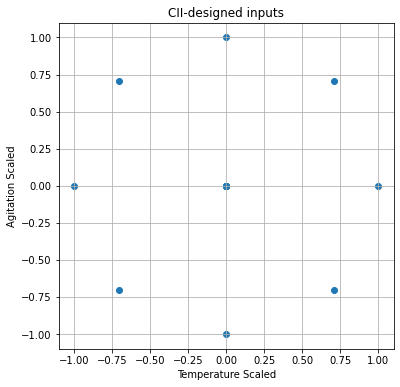

In [7]:
# CCI-Designed DataPoints
plt.figure(figsize=(6,6))
plt.scatter(dfScaled["TemperatureScaled"], dfScaled["AgitationScaled"])
plt.xlabel("Temperature Scaled")
plt.ylabel("Agitation Scaled")
plt.title("CII-designed inputs")
plt.grid()
plt.show()
# plt.savefig("cci.png")

In [8]:
# make quadratic features

poly = PolynomialFeatures(2, include_bias=False)
X = dfScaled[["TemperatureScaled","AgitationScaled"]]
X = pd.DataFrame(poly.fit_transform(X), columns=["T","A","TT","TA","AA"])
Y = dfScaled[["Stress(MPa)","Transmittance(%)"]]

In [9]:
X

,T,A,TT,TA,AA
0,-1.000,0.000000,1.000000,-0.0000,0.000000
1,-0.705,-0.706667,0.497025,0.4982,0.499378
2,-0.705,0.706667,0.497025,-0.4982,0.499378
3,0.000,-1.000000,0.000000,-0.0000,1.000000
4,0.000,0.000000,0.000000,0.0000,0.000000
5,0.000,0.000000,0.000000,0.0000,0.000000
6,0.000,0.000000,0.000000,0.0000,0.000000
7,0.000,0.000000,0.000000,0.0000,0.000000
8,0.000,0.000000,0.000000,0.0000,0.000000
9,0.000,1.000000,0.000000,0.0000,1.000000


In [10]:
Y

,Stress(MPa),Transmittance(%)
0,2.99,75.58
1,3.48,80.40
2,5.24,74.09
3,4.92,71.86
4,6.71,71.49
5,6.45,72.23
6,7.05,67.04
7,6.53,70.38
8,7.12,71.22
9,7.89,68.52


## Regression of Stress

In [11]:
ols = sm.OLS(Y["Stress(MPa)"].values, sm.add_constant(X.values))
resStress = ols.fit()

In [12]:
print(resStress.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     102.2
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           2.19e-06
Time:                        10:03:19   Log-Likelihood:                 3.8701
No. Observations:                  13   AIC:                             4.260
Df Residuals:                       7   BIC:                             7.650
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7720      0.109     61.845      0.0

C:\Users\lusty\miniconda3\envs\py39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [13]:
# AIC based backward elimination
def backwardElimAIC(resFull, features, response):
    """
    resFull: statsmodels' full model result
    features: features X (dataframe), no constant column
    response: response Y (df.series)
    
    """
    full_aic = resFull.aic
    X_full = features
    lowest_aic = [full_aic]
    del_idx = [X_full.columns]
    
    while True:
        aics = []
        for i in range(X_full.shape[1]):
            usecols = list(range(X_full.shape[1]))
            usecols.pop(i)
            X_temp = X_full.iloc[:,usecols]
            ols = sm.OLS(response.values, sm.add_constant(X_temp.values))
            res = ols.fit()
            aics.append(res.aic)
        candidate_aic, candidate_idx = min(aics), np.argmin(aics)
        
        if candidate_aic < lowest_aic[-1]:
            lowest_aic.append(candidate_aic)
            usecols = list(range(X_full.shape[1]))
            usecols.pop(candidate_idx)
            X_full = X_full.iloc[:,usecols]
            del_idx.append(X_full.columns)
        else:
            break
    
    return del_idx, lowest_aic

In [14]:
del_idx, lowest_aic = backwardElimAIC(resStress, X, Y["Stress(MPa)"])

In [15]:
print("modelformula\tAIC")
for i in range(len(lowest_aic)):
    print(*del_idx[i], sep=" + ", end="\t")
    print("{:.3f}".format(lowest_aic[i]))

modelformula	AIC
T + A + TT + TA + AA	4.260
T + A + TT + AA	3.443


In [16]:
X.columns

Index(['T', 'A', 'TT', 'TA', 'AA'], dtype='object')

In [17]:
# removal of interaction term "TA"
ols = sm.OLS(Y["Stress(MPa)"].values, sm.add_constant(X.iloc[:,[0,1,2,4]].values))
res = ols.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     133.1
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           2.37e-07
Time:                        10:03:24   Log-Likelihood:                 3.2783
No. Observations:                  13   AIC:                             3.443
Df Residuals:                       8   BIC:                             6.268
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7720      0.107     63.173      0.0

C:\Users\lusty\miniconda3\envs\py39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [18]:
df

,Entry,Temperature(℃),Agitation(rpm),Stress(MPa),Transmittance(%)
0,1,40.0,35.0,2.99,75.58
1,2,45.9,24.4,3.48,80.40
2,3,45.9,45.6,5.24,74.09
3,4,60.0,20.0,4.92,71.86
4,5,60.0,35.0,6.71,71.49
5,6,60.0,35.0,6.45,72.23
6,7,60.0,35.0,7.05,67.04
7,8,60.0,35.0,6.53,70.38
8,9,60.0,35.0,7.12,71.22
9,10,60.0,50.0,7.89,68.52


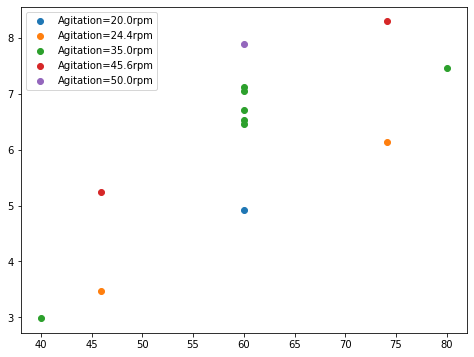

In [19]:
plt.figure(figsize=(8,6))
for val in np.unique(df["Agitation(rpm)"]):
    plt.scatter(df[df["Agitation(rpm)"]==val]["Temperature(℃)"],
             df[df["Agitation(rpm)"]==val]["Stress(MPa)"],
             label=f"Agitation={val}rpm")
plt.legend()
plt.show()

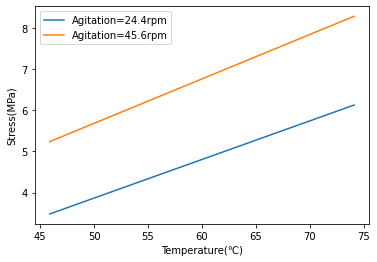

In [20]:
plt.plot(df[df["Agitation(rpm)"]==24.4]["Temperature(℃)"],\
        df[df["Agitation(rpm)"]==24.4]["Stress(MPa)"],\
        label="Agitation=24.4rpm")
plt.plot(df[df["Agitation(rpm)"]==45.6]["Temperature(℃)"],\
        df[df["Agitation(rpm)"]==45.6]["Stress(MPa)"],\
        label="Agitation=45.6rpm")
plt.xlabel("Temperature(℃)")
plt.ylabel("Stress(MPa)")
plt.legend()
plt.show()
# plt.savefig("Temperature-Stress.png")

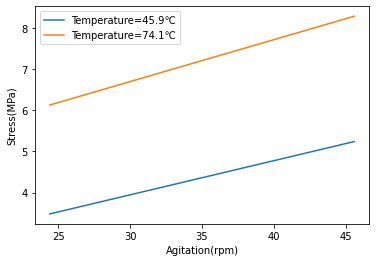

In [21]:
plt.plot(df[df["Temperature(℃)"]==45.9]["Agitation(rpm)"],\
        df[df["Temperature(℃)"]==45.9]["Stress(MPa)"],\
        label="Temperature=45.9℃")
plt.plot(df[df["Temperature(℃)"]==74.1]["Agitation(rpm)"],\
        df[df["Temperature(℃)"]==74.1]["Stress(MPa)"],\
        label="Temperature=74.1℃")
plt.xlabel("Agitation(rpm)")
plt.ylabel("Stress(MPa)")
plt.legend()
plt.show()
# plt.savefig("Agitation-Stress.png")

In [22]:
# surface plot

In [23]:
XX, YY = np.meshgrid(np.linspace(-1,1,30), np.linspace(-1,1,30))
pred_X = pd.DataFrame({"T":XX.ravel(),"A":YY.ravel()})
pred_X["TT"] = pred_X["T"]*pred_X["T"]
pred_X["AA"] = pred_X["A"]*pred_X["A"]

pred_Y_Stress = res.predict(sm.add_constant(pred_X.values))

# back to original scale
XX = ((XX.ravel()+1)/2)*(tempParams["max"]-tempParams["min"])+tempParams["min"]
YY = ((YY.ravel()+1)/2)*(agitParams["max"]-agitParams["min"])+agitParams["min"]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Mesh3d(x=XX,
                        y=YY,
                        z=pred_Y_Stress,
                        opacity=0.5))

fig.add_trace(go.Scatter3d(x=df["Temperature(℃)"].values,
                           y=df["Agitation(rpm)"].values,
                           z=df["Stress(MPa)"].values,
                           mode="markers",
                           marker=dict(size=4, color="blue")))
                            
fig.update_layout(scene = dict(
                    xaxis_title='Temperature',
                    yaxis_title='Agitation',
                    zaxis_title='Stress'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()

In [25]:
# save surface plot
surface = pd.DataFrame({"0":XX.astype(np.float32),
                        "1":YY.astype(np.float32),
                        "2":pred_Y_Stress.astype(np.float32)})
# surface.to_csv("StressSurface.csv", index=True)

## Regression of Transmittance

In [26]:
# full model reg
ols = sm.OLS(Y["Transmittance(%)"].values, sm.add_constant(X.values))
resTransmittance = ols.fit()

In [27]:
print(resTransmittance.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     9.215
Date:                Fri, 05 Nov 2021   Prob (F-statistic):            0.00550
Time:                        10:03:53   Log-Likelihood:                -25.264
No. Observations:                  13   AIC:                             62.53
Df Residuals:                       7   BIC:                             65.92
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.4725      1.030     68.442      0.0

C:\Users\lusty\miniconda3\envs\py39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=13



In [28]:
# AIC based backward elimination
del_idx, lowest_aic = backwardElimAIC(resTransmittance, X, Y["Transmittance(%)"])

In [29]:
for i in range(len(lowest_aic)):
    print(*del_idx[i], sep=" + ", end="\t")
    print("{:.3f}".format(lowest_aic[i]))

T + A + TT + TA + AA	62.528
T + A + TT + TA	60.533
T + A + TA	58.586
T + TA	57.524


In [30]:
X.columns

Index(['T', 'A', 'TT', 'TA', 'AA'], dtype='object')

In [31]:
# T + TA is the best
# but including iteraction term w/o its main effect is not coommon
# thus we use T + A + TA

ols = sm.OLS(Y["Transmittance(%)"].values, sm.add_constant(X.iloc[:,[0,1,3]].values))
res = ols.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     19.65
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           0.000274
Time:                        10:03:56   Log-Likelihood:                -25.293
No. Observations:                  13   AIC:                             58.59
Df Residuals:                       9   BIC:                             60.85
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.5285      0.564    124.956      0.0

C:\Users\lusty\miniconda3\envs\py39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=13



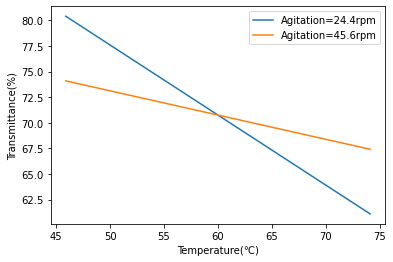

In [32]:
# intersection in two lines -> interaction term

plt.plot(df[df["Agitation(rpm)"]==24.4]["Temperature(℃)"],\
        df[df["Agitation(rpm)"]==24.4]["Transmittance(%)"],\
        label="Agitation=24.4rpm")
plt.plot(df[df["Agitation(rpm)"]==45.6]["Temperature(℃)"],\
        df[df["Agitation(rpm)"]==45.6]["Transmittance(%)"],\
        label="Agitation=45.6rpm")
plt.xlabel("Temperature(℃)")
plt.ylabel("Transmittance(%)")
plt.legend()
# plt.show()
plt.savefig("Temperature-Transmittance.png")

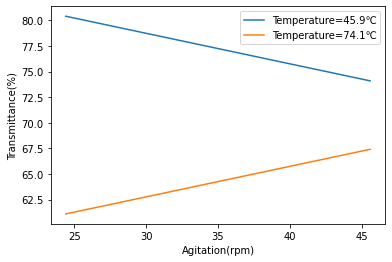

In [33]:
plt.plot(df[df["Temperature(℃)"]==45.9]["Agitation(rpm)"],\
        df[df["Temperature(℃)"]==45.9]["Transmittance(%)"],\
        label="Temperature=45.9℃")
plt.plot(df[df["Temperature(℃)"]==74.1]["Agitation(rpm)"],\
        df[df["Temperature(℃)"]==74.1]["Transmittance(%)"],\
        label="Temperature=74.1℃")
plt.xlabel("Agitation(rpm)")
plt.ylabel("Transmittance(%)")
plt.legend()
# plt.show()
plt.savefig("Agitation-Transmittance.png")

In [34]:
XX, YY = np.meshgrid(np.linspace(-1,1,30), np.linspace(-1,1,30))
pred_X = pd.DataFrame({"T":XX.ravel(),"A":YY.ravel()})
pred_X["TA"] = pred_X["T"]*pred_X["A"]

pred_Y_Transmittance = res.predict(sm.add_constant(pred_X.values))

# back to original scale
XX = ((XX.ravel()+1)/2)*(tempParams["max"]-tempParams["min"])+tempParams["min"]
YY = ((YY.ravel()+1)/2)*(agitParams["max"]-agitParams["min"])+agitParams["min"]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Mesh3d(x=XX,
                        y=YY,
                        z=pred_Y_Transmittance,
                        opacity=0.5,
                        color="red"))

fig.add_trace(go.Scatter3d(x=df["Temperature(℃)"].values,
                           y=df["Agitation(rpm)"].values,
                           z=df["Transmittance(%)"].values,
                           mode="markers",
                           marker=dict(size=4, color="red")))
                            
fig.update_layout(scene = dict(
                    xaxis_title='Temperature',
                    yaxis_title='Agitation',
                    zaxis_title='Transmittance'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()

In [36]:
# save surface
surfaceTransmittance = pd.DataFrame({"0":XX.astype(np.float32),
                        "1":YY.astype(np.float32),
                        "2":pred_Y_Transmittance.astype(np.float32)})
# surfaceTransmittance.to_csv("TransmittanceSurface.csv", index=True)

In [37]:
surfaceTransmittance = pd.DataFrame({"0":XX.astype(np.float32),
                        "1":YY.astype(np.float32),
                        "2":(pred_Y_Transmittance/10).astype(np.float32)})
# surfaceTransmittance.to_csv("TransmittanceSurfaceScaled.csv", index=True)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Mesh3d(x=XX,
                        y=YY,
                        z=pred_Y_Stress,
                        opacity=0.5,
                        name="Stress"))

fig.add_trace(go.Mesh3d(x=XX,
                        y=YY,
                        z=pred_Y_Transmittance/10,
                        opacity=0.5,
                        name="Transmittance"))

fig.add_trace(go.Scatter3d(x=df["Temperature(℃)"].values,
                           y=df["Agitation(rpm)"].values,
                           z=df["Stress(MPa)"].values,
                           mode="markers",
                           name="Stress_Surface",
                           marker=dict(size=4, color="blue")))

fig.add_trace(go.Scatter3d(x=df["Temperature(℃)"].values,
                           y=df["Agitation(rpm)"].values,
                           z=df["Transmittance(%)"].values/10,
                           mode="markers",
                           name="Transmittance_Surface",
                           marker=dict(size=4, color="red")))
                            
fig.update_layout(scene = dict(
                    xaxis_title='Temp',
                    yaxis_title='Agitatio',
                    zaxis_title='Responce'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()